In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1_array = np.asarray(v_err1)
#Express as weights
weighdata = (1/v_err1)

In [3]:
# Function for fitting all parameters (n, re, h)
#def f(r,M,rc,rho00,c,n,re,h,pref):
#    return np.sqrt(nf.bh_v(r,M)**2 
#                   + nf.h_v(r,rc,rho00,load=True)**2 
#                   + c**2*nf.b_v(r,n,reload=True)**2 
#                   + nf.d_v(r,h,pref,load=True)**2)

# Function for fitting only prefactors + halo's parameters
#def g(r,M,rc,rho00,c,pref):
#    return np.sqrt(nf.bh_v(r,M,load=True)**2 
#                   + nf.h_v(r,rc,rho00,load=True)**2 
#                   + c**2*nf.b_v(r,load=True)**2 
#                   + pref**2*nf.d_v(r,load=True)**2)

# Function for fitting only prefactors + halo's parameters
def g(r,M,rc,rho00,c,pref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 
                   + nf.h_v(r,rc,rho00,load=True)**2 
                   + c**2*nf.b_v(r,load=True)**2 
                   + pref**2*nf.d_thief(r)**2)

print(g(1,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))
print(g(5,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))

[278.90908857]
[276.74232172]


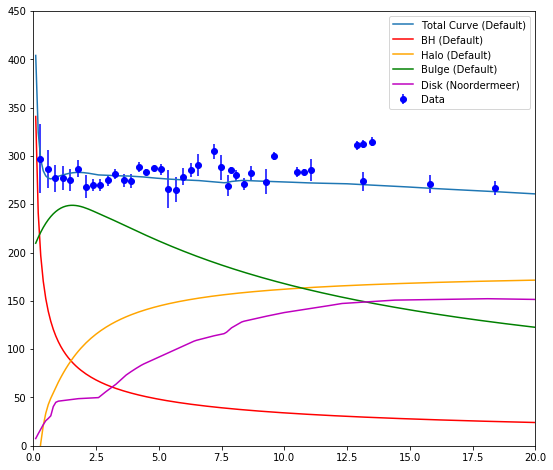

In [4]:
#Plot 

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,20)
plt.ylim(0,450)

rval = np.arange(0.1,200,0.1)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1),label='Total Curve (Default)')
plt.plot(rval,nf.bh_v(rval,load=True),color='r',label='BH (Default)')
plt.plot(rval,nf.h_v(rval,load=True),color='orange',label='Halo (Default)')
plt.plot(rval,nf.b_v(rval,load=True),color='g',label='Bulge (Default)')
#plt.plot(rval,nf.d_v(rval,load=True),color='m',label='Disk (Default)')
plt.plot(rval,nf.d_thief(rval),color='m',label='Disk (Noordermeer)')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

In [5]:
# Fit, using all parameters

#Setup
#l_mod = lm.Model(f)
#l_params = l_mod.make_params()
#Black Hole
#l_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
#l_params.add('c', value=1, min=0)          #Contributions should all add
#l_params.add('n', value=nf.n_c, min=0)
#l_params.add('re', value=nf.re_c, min=0)
#Disk
#l_params.add('pref', value=nf.pref_def, min=0, max=1000)
#l_params.add('h', value=nf.h_c, min=0, max=1000)
#Halo
#l_params.add('rc', value=nf.h_rc, min=0)   #Radius (magnitude)
#l_params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Do fit
#l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [6]:
# Fit, using prefactors

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Black Hole
g_params.add('M', value=nf.Mbh_def, min=1.0e8) #Mass
#Halo
g_params.add('rc', value=nf.h_rc, min=0.1)   #Radius (magnitude)
g_params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Bulge
g_params.add('c', value=1,min=0,max=100)          #Contributions should all add
#Disk
g_params.add('pref', value=1,min=0, max=100)

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [7]:
#Define for plotting

bestg = g_fit.best_fit
delg = g_fit.eval_uncertainty()

In [8]:
#print('Fit information for all-component fit, no prefactor:')
#l_fit

In [9]:
print('Fit information for all-component fit, prefactor:')
g_fit

Fit information for all-component fit, prefactor:


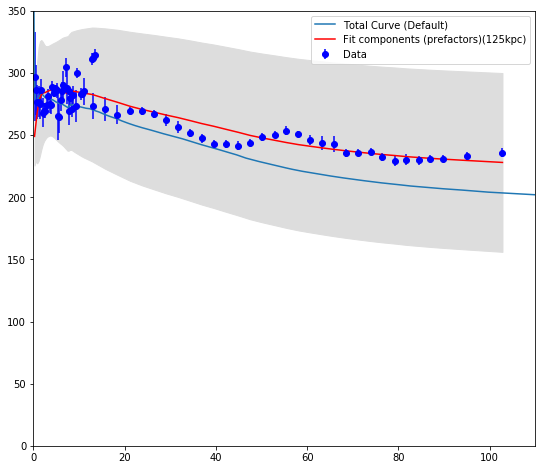

In [10]:
#Plot to 110kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,110)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (125kpc)')
plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1),label='Total Curve (Default)')
plt.plot(r_dat,bestg,'r-',label='Fit components (prefactors)(125kpc)')
plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd')

plt.legend()
plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

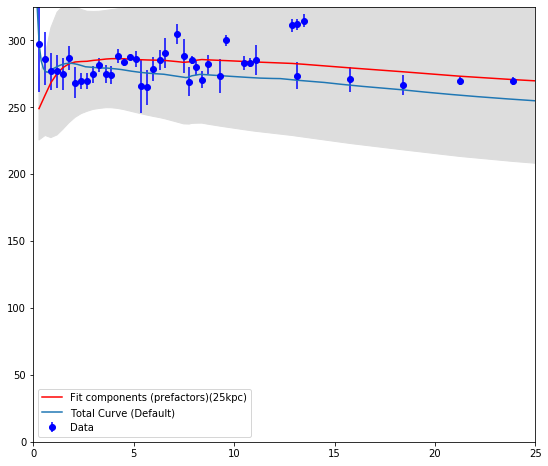

In [11]:
#Plot to 25kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)
plt.ylim(0,325)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')
plt.plot(r_dat,bestg,'r-',label='Fit components (prefactors)(25kpc)')
plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd')
plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1),label='Total Curve (Default)')

plt.legend()
plt.savefig('Fitting_allcomponents_25kpc.png')
plt.show()

In [12]:
#Define for plotting cont.

g_dict = g_fit.best_values
g_M = g_dict['M']
g_c = g_dict['c']
g_pref = g_dict['pref']
g_rc = g_dict['rc']
g_hrho00 = g_dict['rho00']

g_curve = g(rval,g_M,g_rc,g_hrho00,g_c,g_pref)
bh_curve = nf.bh_v(rval,g_M)
halo_curve = nf.h_v(rval,g_rc,g_hrho00)
bulge_curve = g_c*nf.b_v(rval, load=True)
disk_curve = g_pref*nf.d_v(rval, load=True)

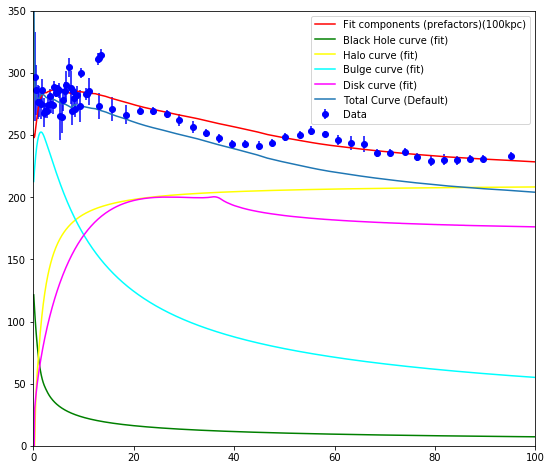

In [13]:
#Plot each fitted component to 100kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,100)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(rval,g_curve,'r-',label='Fit components (prefactors)(100kpc)')
plt.plot(rval,bh_curve,'green',label='Black Hole curve (fit)')
plt.plot(rval,halo_curve,'yellow',label='Halo curve (fit)')
plt.plot(rval,bulge_curve,'cyan',label='Bulge curve (fit)')
plt.plot(rval,disk_curve,'magenta',label='Disk curve (fit)')

plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1),label='Total Curve (Default)')

plt.legend()
plt.savefig('Fitting_allcomponents_100kpc.png')
plt.show()

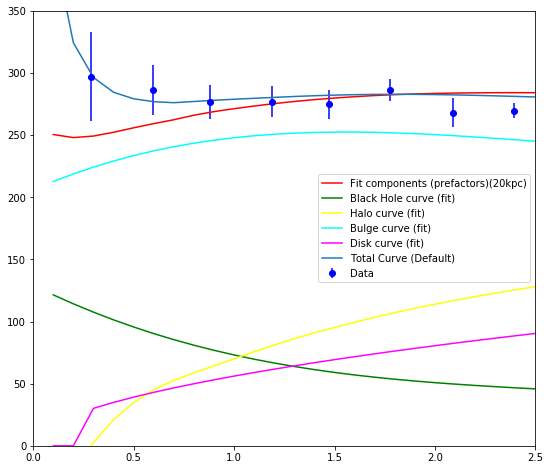

In [14]:
#Plot each fitted component to 20kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,2.5)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(rval,g_curve,'r-',label='Fit components (prefactors)(20kpc)')
plt.plot(rval,bh_curve,'green',label='Black Hole curve (fit)')
plt.plot(rval,halo_curve,'yellow',label='Halo curve (fit)')
plt.plot(rval,bulge_curve,'cyan',label='Bulge curve (fit)')
plt.plot(rval,disk_curve,'magenta',label='Disk curve (fit)')

plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1),label='Total Curve (Default)')

plt.legend()
plt.savefig('Fitting_allcomponents_20kpc.png')
plt.show()

In [15]:
# Explanation of parameters 

# Bulge
print('Bulge')
print('Scaling constant,         C = {:.2f}'.format(g_c))

print('')


# Disk
print('Disk')
print('Scaling constant,         prefactor = {:.3f}'.format(g_pref))

print('')


# Black Hole
print('Black Hole')
print('Mass of the Black Hole,   M(bh) = {:.3e} [solar masses]'.format(g_M))
print('')


# Dark Halo
print('Dark Halo')
print('Halo central density,     rho00 = {:.3e} [solar mass/kpc^3]'.format(g_hrho00))
print('Core radius,              rc = {:.2f} [kpc]'.format(g_rc))


Bulge
Scaling constant,         C = 1.01

Disk
Scaling constant,         prefactor = 0.942

Black Hole
Mass of the Black Hole,   M(bh) = 1.220e+09 [solar masses]

Dark Halo
Halo central density,     rho00 = 3.394e+08 [solar mass/kpc^3]
Core radius,              rc = 1.56 [kpc]


In [16]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total Time:
7.8141560554504395 seconds

Timestamp:
2019-11-15 13:30:29.278182
